# Pretrained Network | Feature Extractor

El objetivo de esta sección es ver como implementar transfer-learning cuando tenemos una cantidad de datos disponible limitada, pero el dominio del objetivo es similar a la red que queremos usar.

Congelaremos la parte de extracción de features de la red VGG16 entrenada en el dataset IMAGENET, y agregaremos nuestro propio clasificador, para después reentrenar la red con nuestro pequeño dataset.

Otro de los objetivos será mostrar como preprocesar nuestros datos para conseguir entrenar una red.

Notesé que ya no calculamos MEAN y STD para normalizar aquí, si no que usamos los valores estandard (calculados por la comunidad) para rapidez

Además no usaremos data-augmentation aqui.

In [1]:
from torchvision import models, datasets, transforms
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary

#Obtenemos los pesos de la red VGG16 entrenada en el dataset IMAGENET

weights = models.VGG16_Weights.IMAGENET1K_V1

#Como vemos aqui observamos los valores a los que nuestro dataset debe ser normalizado
# y preprocesado para que la red pueda usarlo.

preprocess = weights.transforms()
print(preprocess)
IMAGENET_MEAN = preprocess.mean
IMAGENET_STD  = preprocess.std

print(IMAGENET_MEAN)
print(IMAGENET_STD)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
[0.485, 0.456, 0.406]
[0.229, 0.224, 0.225]


Como vemos arriba:

### crop_size=[224]

Es el tamaño final de la imagen que el modelo usa como entrada: 224×224 píxeles.
Se consigue aplicando transforms.CenterCrop(224) después del resize.

### resize_size=[256]

Antes del recorte, la imagen se redimensiona de forma que su lado más corto mida 256 píxeles, manteniendo su proporción.
Esto equivale a transforms.Resize(256)

También observamos la media y desviación estandard que usaremos para la normalización.

Este pipeline que hemos visto arriba, tenemos que replicarlo en nuestro dataset.

In [2]:


# Replicamos el pipeline de preprocesado de la red VGG16
base_tf = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR), # Redimensiona la imagen
    transforms.CenterCrop(224), # Recorta la imagen
    transforms.ToTensor(), # Convierte la imagen a un tensor
    transforms.Normalize(weights.transforms().mean, weights.transforms().std), # Normaliza la imagen
])

root = "./data/01"
train_ds = datasets.ImageFolder(f"{root}/train", transform=base_tf)
valid_ds = datasets.ImageFolder(f"{root}/valid", transform=base_tf)
test_ds  = datasets.ImageFolder(f"{root}/test",  transform=base_tf)

loader_train = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True)                       
loader_val   = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)
loader_test  = DataLoader(test_ds,  batch_size=len(test_ds),  shuffle=False)


In [ ]:
# Definimos GPU o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Obtenemos el numero de clases de nuestro dataset
num_classes = len(train_ds.classes)

# Definimos la base de la red VGG16
base = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)



#Vamos a imprimir los parametros de la red VGG16
# Calculamos parámetros
trainable_params = sum(p.numel() for p in base.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in base.parameters())
frozen_params    = total_params - trainable_params

print(f"Trainable: {trainable_params:,} | Frozen: {frozen_params:,} | Total: {total_params:,}")



Trainable: 138,357,544 | Frozen: 0 | Total: 138,357,544


In [ ]:

# Congelamos los parametros de la red VGG16
# Aqui le decimos que no calcule los gradientes para los parametros de la red VGG16
# Esto es importante, ya que si no lo hacemos, el modelo se entrenará desde cero
# y no aprovechará los pesos ya entrenados de la red VGG16-Imagenet
for p in base.features.parameters():
    p.requires_grad = False
#Ponemos la red en modo evaluación por tuviera batchnorm, o dropout para usar el mismo mean y std de train y no del batch.
#EN VGG16, no tiene batchnorm, pero en otros modelos si puede haberlo.
#Simple seguridad
base.eval()

# Vamos a volver a calcular los parametros de la red VGG16, para ver que se han congelado
# Calculamos parámetros
trainable_params = sum(p.numel() for p in base.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in base.parameters())
frozen_params    = total_params - trainable_params

print(f"Trainable: {trainable_params:,} | Frozen: {frozen_params:,} | Total: {total_params:,}")




Trainable: 123,642,856 | Frozen: 14,714,688 | Total: 138,357,544


Como vemos, los parametros entrenables, se han reducido, a continuación, vamos a quedarnos con toda la red, salvo el clasificador, ya que crearemos uno para nuestro caso de uso. (2 clases)

Como veremos en el output, al quitar el clasificador, ya no tenemos parametros entrenables, los que quedan de las capas de convolución estan congelados.

In [5]:
backbone = nn.Sequential(*(list(base.children())[:-1])) 

# Vemos que los parametros entrenables se han reducido a 0
trainable_params = sum(p.numel() for p in backbone.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in backbone.parameters())
frozen_params    = total_params - trainable_params

print(f"Trainable: {trainable_params:,} | Frozen: {frozen_params:,} | Total: {total_params:,}")

print(summary(backbone, (3, 224, 224)))

Trainable: 0 | Frozen: 14,714,688 | Total: 14,714,688
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]  

Para volver a tener parametros entreables desde 0, tendremos que añadir nuestra propia capa de clasificación a la red.

In [6]:

# Definimos el clasificador
head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512*7*7, 64), # 512 es el numero de features de la ultima capa de convolución y 7*7 es el tamaño de la imagen de entrada.
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes)
    #No añadimos activacion al final, ya que usaremos CrossEntropyLoss que aplica la activacion softmax.
)


Ahora construimos backbone + clasificador

Notemos que ahora volvemos a tener parametros entrenables, pero estos son inferiores a la red completa antes de descabezarla, ya que tenemos solo 2 clases.

In [7]:
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model = VGG16FeatureExtractor(backbone, head).to(device)

print(summary(model, (3, 224, 224)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Vamos a definir optimizar y funcion de error

In [8]:
#Se optimiza solo el clasificador, entramos como parametro.
import torch.optim as optim
from datetime import datetime
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score
NUM_CLASSES = 2 
TENSORBOARD_EXP = f"runs/vgg16_imgnet_2cls_featextractor_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
precision_metric = MulticlassPrecision(num_classes=NUM_CLASSES, average="macro").to(device)
recall_metric    = MulticlassRecall(num_classes=NUM_CLASSES, average="macro").to(device)
f1_metric        = MulticlassF1Score(num_classes=NUM_CLASSES, average="macro").to(device)
EPOCHS = 20

#Se optimiza solo el clasificador, entramos como parametro.
optimizer = optim.Adam(model.head.parameters(), lr=0.0001)


criterion = torch.nn.CrossEntropyLoss()

model.to(device)


VGG16FeatureExtractor(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=T

In [9]:
from torch.utils.tensorboard import SummaryWriter
import torch

writer = SummaryWriter(log_dir=TENSORBOARD_EXP)

def evaluate(model, loader, device, criterion):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total



train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, loader_val, device, criterion)

    precision_metric.reset(); recall_metric.reset(); f1_metric.reset()
    with torch.no_grad():
        for images, labels in loader_val:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_metric.update(preds, labels)
    precision_val = precision_metric.compute().item()
    recall_val    = recall_metric.compute().item()
    f1_val        = f1_metric.compute().item()

    writer.add_scalar("Val/Precision_macro", precision_val, epoch)
    writer.add_scalar("Val/Recall_macro",    recall_val,  epoch)
    writer.add_scalar("Val/F1_macro",        f1_val,      epoch)

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accuracies.append(train_acc); val_accuracies.append(val_acc)

    print(f"Época {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val",   val_loss,  epoch)
    writer.add_scalar("Acc/train",  train_acc, epoch)
    writer.add_scalar("Acc/val",    val_acc,   epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)
    writer.flush()

test_loss, test_acc = evaluate(model, loader_test, device, criterion)

hparams = {
    'model': model.__class__.__name__,
    'seed': 3,
    'optimizer': optimizer.__class__.__name__,
    'lr_init': float(optimizer.param_groups[0]['lr']),
    'batch_size': int(loader_train.batch_size),
}

metrics = {
    'metrics/test_acc': float(test_acc),
    'metrics/test_loss': float(test_loss),
    'metrics/val_acc_last': float(val_accuracies[-1]),
    'metrics/val_loss_last': float(val_losses[-1]),
    'metrics/train_acc_last': float(train_accuracies[-1]),
    'metrics/train_loss_last': float(train_losses[-1]),
}

writer.add_hparams(hparams, metrics)
writer.close()


Época 1/20 | Train Loss: 0.7673 | Train Acc: 0.5941 | Val Loss: 0.4939 | Val Acc: 0.8155
Época 2/20 | Train Loss: 0.3078 | Train Acc: 0.9158 | Val Loss: 0.3694 | Val Acc: 0.8738
Época 3/20 | Train Loss: 0.1794 | Train Acc: 0.9752 | Val Loss: 0.2845 | Val Acc: 0.9320
Época 4/20 | Train Loss: 0.1141 | Train Acc: 0.9950 | Val Loss: 0.2231 | Val Acc: 0.9612
Época 5/20 | Train Loss: 0.0937 | Train Acc: 1.0000 | Val Loss: 0.1788 | Val Acc: 0.9709
Época 6/20 | Train Loss: 0.0721 | Train Acc: 1.0000 | Val Loss: 0.1482 | Val Acc: 0.9709
Época 7/20 | Train Loss: 0.0557 | Train Acc: 1.0000 | Val Loss: 0.1280 | Val Acc: 0.9709
Época 8/20 | Train Loss: 0.0507 | Train Acc: 1.0000 | Val Loss: 0.1149 | Val Acc: 0.9709
Época 9/20 | Train Loss: 0.0426 | Train Acc: 1.0000 | Val Loss: 0.1061 | Val Acc: 0.9515
Época 10/20 | Train Loss: 0.0400 | Train Acc: 1.0000 | Val Loss: 0.1003 | Val Acc: 0.9515
Época 11/20 | Train Loss: 0.0373 | Train Acc: 1.0000 | Val Loss: 0.0965 | Val Acc: 0.9515
Época 12/20 | Train

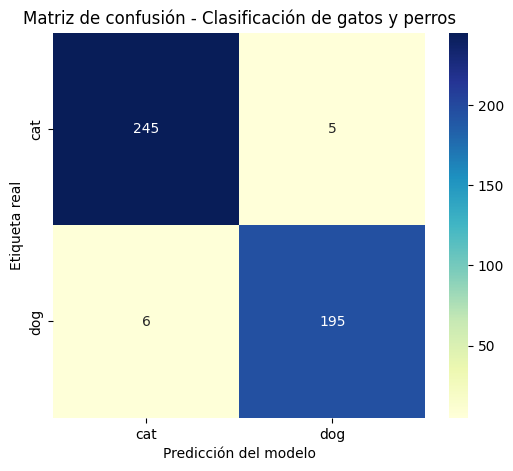


INTERPRETACIÓN:
245 gatos clasificados correctamente como gatos (True Positives - cats)
5 gatos clasificados incorrectamente como perros (False Negatives - cats)
6 perros clasificados incorrectamente como gatos (False Positives - dogs)
195 perros clasificados correctamente como perros (True Positives - dogs)

Precisión gatos: 0.980 (245/250)
Precisión perros: 0.970 (195/201)
Accuracy global: 0.976


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluamos el modelo en el conjunto de test
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for x, y in loader_test:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Calculamos la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
classes = train_ds.classes  # ['cat', 'dog']

# Mostramos la matriz como un mapa de calor
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción del modelo")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión - Clasificación de gatos y perros")
plt.show()

# Interpretación explícita
print("\nINTERPRETACIÓN:")
print(f"{cm[0,0]} gatos clasificados correctamente como gatos (True Positives - cats)")
print(f"{cm[0,1]} gatos clasificados incorrectamente como perros (False Negatives - cats)")
print(f"{cm[1,0]} perros clasificados incorrectamente como gatos (False Positives - dogs)")
print(f"{cm[1,1]} perros clasificados correctamente como perros (True Positives - dogs)")

# Métricas derivadas por clase (para reforzar comprensión)
total_cats = cm[0].sum()
total_dogs = cm[1].sum()
acc_cat = cm[0,0] / total_cats
acc_dog = cm[1,1] / total_dogs

print(f"\nPrecisión gatos: {acc_cat:.3f} ({cm[0,0]}/{total_cats})")
print(f"Precisión perros: {acc_dog:.3f} ({cm[1,1]}/{total_dogs})")
print(f"Accuracy global: {(cm.trace() / cm.sum()):.3f}")
